# Imports and Paths 

## Shared Libraries

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import itertools

## Plotting Parameters

In [2]:
from palettable.cartocolors.qualitative import Prism_8

prism = Prism_8.mpl_colors
blue = prism[1]
green = prism[3]
purple = prism[0]
red = prism[7]
orange = prism[6]
yellow = prism[5]
gray = "#303039"

In [3]:
style = "/Users/gleung/OneDrive - Colostate/03 Resources/00 Code Repository/styles/bee-paperlight.mplstyle"
plt.style.use(style)

## Define paths

In [14]:
dataPath = (
    "/Users/gleung/OneDrive - Colostate/01 Projects/04.11_DroneChimney/00_Data/"
)

figPath = "/Users/gleung/OneDrive - Colostate/01 Projects/04.11_DroneChimney/02_Figures/"

# Process stacked drone logs

We want to define the flight segments where the stacked drones are at altitude, and match these up with the corresponding iMet sensor data. First, let's take the drone logs manually taken during BACS-II as an inital guess for in-stack/out-of-stack times. Within each of those time periods, determine the variability in the altitude over a moving 30s period. If the altitude has reached within 50m of the maximum flight altitude (which we will call the target altitude) and the variability in the altitude is <=2m over the moving window, assign at-altitude flag to be true. Then fill in small gaps in the at-altitude flag (if they are smaller than say, 10s).

## Read-in manual flight logs

In [7]:
# This is the  manual flight log from BACS-II
log = pd.read_excel(f"{dataPath}log.xlsx", parse_dates=True)
log = log.rename(
    columns={
        "Date ": "Date",
        "Drone Altitude (m)": "Alt",
        "Takeoff TIme": "Takeoff",
        "Landing Time": "Landing",
        "In-stack time": "Instack",
        "Out-of-stack time": "Outstack",
        "iMet (Aspirated)": "Aspirated",
        "iMet (Unaspirated) Name": "Unaspirated",
    }
)
log = log[
    [
        "Date",
        "IOP",
        "Drone",
        "Flight Number",
        "Alt",
        "Takeoff",
        "Landing",
        "Instack",
        "Outstack",
        "Aspirated",
        "Unaspirated",
    ]
]

# don't include data from the first & last IOPs where we weren't using
# aspirated + unaspirated sensors anyway
log = log[(log.IOP > 15) & (log.IOP < 28)]

# exclude PJ since that was the profiler drone
log = log[~log.Drone.isin(["PJ", "Pj"])]

# exclude flights where we don't have takeoff/in-stack time recorder
log = log[~log.Takeoff.isnull()]
log = log[~log.Instack.isnull()]


for var in ["Takeoff", "Landing", "Instack", "Outstack"]:
    log[var] = [
        dt.datetime.combine(d.date(), t) for d, t in zip(log.Date, log[var])
    ]

    # all the flights were done in late morning to evening period local time,
    # so just convert everything to 24-hr time appropriately
    log.loc[log[~log[var].dt.hour.isin([10, 11, 12])].index, var] = log[
        ~log[var].dt.hour.isin([10, 11, 12])
    ][var] + dt.timedelta(hours=12)

    # convert local time to UTC
    log[f"{var}UTC"] = log[var] + dt.timedelta(hours=6)

# remove any flight segments that didn't have aspirated AND unaspirated sensors
log = log[(~log.Aspirated.isnull()) & (~log.Unaspirated.isnull())]

## Coordinate with iMet values

In [8]:
imetCols = [
    "XQ-iMet-XQ Pressure",
    "XQ-iMet-XQ Air Temperature",
    "XQ-iMet-XQ Humidity",
    "XQ-iMet-XQ Humidity Temp",
    "XQ-iMet-XQ Date",
    "XQ-iMet-XQ Time",
    "XQ-iMet-XQ Longitude",
    "XQ-iMet-XQ Latitude",
    "XQ-iMet-XQ Altitude",
    "XQ-iMet-XQ Sat Count",
]

imetnewCols = [
    "P",
    "Temp",
    "RH",
    "Temp_RH",
    "Date",
    "Time",
    "Lon",
    "Lat",
    "Alt",
    "SatCount",
]

In [9]:
def split_consecutive_groups(lst):
    # this is a function to split list into groups of repeated values
    return [list(group) for key, group in itertools.groupby(lst)]

In [88]:
for t in log.index:
    flt = log.loc[t]

    print(flt.IOP, flt["Flight Number"], flt.Drone)

    # make sure both aspirated and unaspirated iMet files exist
    if os.path.exists(
        f"{dataPath}/imet/{flt.Aspirated}-{flt.Date.strftime('%Y%m%d')}.csv"
    ) and os.path.exists(
        f"{dataPath}/imet/{flt.Unaspirated}-{flt.Date.strftime('%Y%m%d')}.csv"
    ):

        # read aspirated imet
        aPath = (
            f"{dataPath}/imet/{flt.Aspirated}-{flt.Date.strftime('%Y%m%d')}.csv"
        )
        a = pd.read_csv(aPath, parse_dates=True)
        a = a[imetCols]
        a.columns = imetnewCols

        #remove any dates that aren't valid
        a = a[a.Date.str[:4] == "2023"]
        a = a[a.Date.str[8:10] != "00"]

        # keep only timesteps where there are sufficient GPS satellites  
        a = a[a.SatCount > 0]

        # use manual takeoff/landing times as initial guess
        a["Datetime"] = pd.to_datetime(a.Date + " " + a.Time)
        a = a[
            (a.Datetime >= flt.TakeoffUTC - dt.timedelta(minutes=0))
            & (a.Datetime <= flt.LandingUTC + dt.timedelta(minutes=0))
        ]
        a = a.reset_index()

        # as above, but for unaspirated imet
        uPath = f"{dataPath}/imet/{flt.Unaspirated}-{flt.Date.strftime('%Y%m%d')}.csv"
        u = pd.read_csv(uPath, parse_dates=True)
        u = u[imetCols]
        u.columns = imetnewCols
        u = u[u.Date.str[:4] == "2023"]
        u = u[u.Date.str[8:10] != "00"]
        u = u[u.SatCount > 0]
        u["Datetime"] = pd.to_datetime(u.Date + " " + u.Time)
        u = u[
            (u.Datetime >= flt.TakeoffUTC - dt.timedelta(minutes=0))
            & (u.Datetime <= flt.LandingUTC + dt.timedelta(minutes=0))
        ]
        u = u.reset_index()

        # only consider segments > 1min data (60s)
        if len(u) > 60:
            fig, axes = plt.subplots(4, 1, sharex=True, figsize=(6, 12))

            # take rolling standard deviation over 30s window
            u["AltVar"] = u.Alt.rolling(30).std(center=True)
            u["LatVar"] = u.Lat.rolling(30).std(center=True)
            u["LonVar"] = u.Lon.rolling(30).std(center=True)

            targetalt = u.Alt.max() - 50

            u["altflag"] = (
                #within 50m of the max altitude reached
                (u.Alt >= targetalt)
                #standard deviation in altitude is < 2m
                & (u.AltVar <= 2)
                # and in lat/lon is approx ~2m
                & (u.LatVar <= 2e-5)
                & (u.LonVar <= 2e-5)
            )

            axes[1].scatter(
                u[u.altflag == 1].Datetime,
                u[u.altflag == 1].Alt,
                marker="o",
                s=1,
                label="At-Altitude",
                zorder=10,
                color="gray",
            )

            # find groups where altitude flag is consecutive 1 or 0
            grps = split_consecutive_groups(u["altflag"])
            lens = np.array([len(l) for l in grps])
            cumlen = lens.cumsum()
            idx = np.max([len(l) for l in grps if l[0]])
            nstart = np.where(lens == idx)[0][0]
            start = np.sum(lens[:nstart])
            stop = lens[nstart] + start

            # starting from the longest contiguous segment where flag = 1 (drone is at altitude)
            # look forward at next segment in time, if the segment where flag = 0 is less than 30s long,
            # join the two sections where flag = 1 
            for i, l in enumerate(lens[nstart:-2]):
                if lens[nstart + i + 1] < 30:
                    stop += lens[nstart + i + 1] + lens[nstart + i + 2]
                else:
                    break

            # same as above but backward in time
            for i, l in enumerate(lens[1 : nstart - 1][::-1]):
                if lens[nstart - i - 1] < 30:
                    start += -(lens[nstart - i - 1] + lens[nstart - i - 2])
                else:
                    break

            u["altflag"] = 0
            u.loc[start:stop, "altflag"] = 1

            # assign new start and end time to log dataframe
            log.loc[t, "starttime"] = u[u.altflag == 1].Datetime.iloc[0]
            log.loc[t, "endtime"] = u[u.altflag == 1].Datetime.iloc[-1]

        
            # make plots per flight segment

            axes[0].plot(
                u.Datetime,
                u.Temp,
                color="black",
                label=f"Unshielded {flt.Unaspirated}",
            )
            axes[0].plot(
                a.Datetime, a.Temp, color=red, label=f"Shielded {flt.Aspirated}"
            )
            axes[0].legend()
            axes[0].set_ylabel("$^{\circ}$C")
            axes[0].set_title("(a) Temperature")

            axes[1].plot(u.Datetime, u.Alt, color="black")
            axes[1].scatter(
                u[u.altflag == 1].Datetime,
                u[u.altflag == 1].Alt,
                marker="o",
                s=1,
                label="At-Altitude",
                zorder=10,
            )
            axes[1].set_title("(b) Altitude")
            axes[1].set_ylabel("m (MSL)")

            ax = axes[1].twinx()
            ax.plot(u.Datetime, u.AltVar, color="gray")
            ax.axhline(2, ls="--", color="gray", lw=1, zorder=0)
            ax.set_ylabel("Variability", color="gray")
            ax.spines["right"].set_edgecolor("gray")
            ax.tick_params(axis="y", colors="gray")

            axes[2].plot(u.Datetime, u.Lat, color="black")
            axes[2].set_title("(c) Latitude")

            axes[2].get_yaxis().get_major_formatter().set_useOffset(False)
            ax = axes[2].twinx()
            ax.plot(u.Datetime, u.LatVar, color="gray")
            ax.axhline(2e-5, ls="--", color="gray", lw=1, zorder=0)
            ax.set_ylabel("Variability", color="gray")
            ax.spines["right"].set_edgecolor("gray")
            ax.tick_params(axis="y", colors="gray")

            axes[3].plot(u.Datetime, u.Lon, color="black")
            axes[3].set_title("(d) Longitude")
            axes[3].get_yaxis().get_major_formatter().set_useOffset(False)
            ax = axes[3].twinx()
            ax.plot(u.Datetime, u.LonVar, color="gray")
            ax.axhline(2e-5, ls="--", color="gray", lw=1, zorder=0)
            ax.set_ylabel("Variability", color="gray")
            ax.spines["right"].set_edgecolor("gray")
            ax.tick_params(axis="y", colors="gray")

            for ax in axes:
                ax.axvline(u[u.altflag == 1].Datetime.iloc[0])
                ax.axvline(u[u.altflag == 1].Datetime.iloc[-1])

            plt.suptitle(
                f"IOP {flt.IOP}, Flight {flt['Flight Number']}, Altitude {flt.Alt}m",
                fontsize=20,
                ha="center",
                va="center",
            )

            plt.savefig(
                f"{figPath}/stack_identification/{flt.IOP}_{flt['Flight Number']}_{flt.Alt:.0f}.png"
            )
            plt.close("all")

17 1 St
17 1 Ac
17 1 Cb
17 2 St
17 2 Ac
17 2 Cb
17 3 St
17 3 Ac
17 3 Cb
18 1 St
18 2 St
18 3 St
18 4 St
18 5 St
18 6 St
18 7 St
18 1 Ac
18 2 Ac
18 3 Ac
18 4 Ac
18 5 Ac
18 6 Ac
18 7 Ac
18 1 Cb
18 2 Cb
18 3 Cb
18 4 Cb
18 5 Cb
18 6 Cb
18 7 Cb
19 1 Cb
19 2 Cb
19 3 Cb
19 4 Cb
19 5 Cb
19 1 Ac
19 2 Ac
19 3 Ac
19 4 Ac
19 5 Ac
19 1 St
19 2 St
19 3 St
19 4 St
19 5 St
20 1 Cb
20 2 Cb
20 3 Cb
20 4 Cb
20 1 Ac
20 2 Ac
20 3 Ac
20 4 Ac
20 1 St
20 2 St
20 3 St
20 4 St
21 1 Ac
21 1 St
21 1 Cb
22 1 St
22 2 St
22 3 St
22 1 Cb
22 2 Cb
22 3 Cb
23 1 Ac
23 2 Ac
23 3 Ac
23 4 Ac
23 5 Ac
23 6 Ac
23 7 Ac
23 1 St
23 2 St
23 3 St
23 4 St
23 5 St
23 6 St
23 7 St
23 1 Cb
23 2 Cb
23 3 Cb
23 4 Cb
23 5 Cb
23 6 Cb
23 7 Cb
24 1 St
24 2 St
24 3 St
24 1 Cb
24 2 Cb
24 3 Cb
25 1 Cb
25 2 Cb
25 3 Cb
25 4 Cb
25 5 Cb
25 6 Cb
25 7 Cb
25 1 St
25 2 St
25 3 St
25 4 St
25 5 St
25 6 St
25 7 St
25 1 Ac
25 2 Ac
25 3 Ac
25 4 Ac
25 5 Ac
25 6 Ac
25 7 Ac
26 1 Ac
26 2 Ac
26 3 Ac
26 4 Ac
26 5 Ac
26 6 Ac
26 1 St
26 2 St
26 3 St
26 4 St
26 5 St


In [92]:
#remove any segments less than 1 min long

log = log[(log.endtime - log.starttime) > dt.timedelta(minutes=1)]

In [93]:
log.to_csv(f"{dataPath}/stack_log.csv")

# Calculate autocorrelation and efolding times

In [155]:
def autocorr(x):
    # first standardize values in x
    x = (x - x.mean()) / x.std()

    # calculate autocorrelation (see Libby's OA notes/github for reference)
    r = np.correlate(x, x, mode="same") / (np.var(x) * np.size(x))
    r = r[int(np.size(x) / 2) :]
    return r


def etime(auto, dt=1):
    # calculate e-folding time as the point at which autocorrelation is just above > 1/e
    return (auto > (1 / np.e)).sum() * dt

In [96]:
a = []

for i in log.index[::-1]:
    flt = log.loc[i]
    out = []
    if os.path.exists(
        f"{dataPath}/imet/{flt['Aspirated']}-{flt.Date.strftime('%Y%m%d')}.csv"
    ) & os.path.exists(
        f"{dataPath}/imet/{flt['Unaspirated']}-{flt.Date.strftime('%Y%m%d')}.csv"
    ):

        for ver in ["Aspirated", "Unaspirated"]:
            path = (
                f"{dataPath}/imet/{flt[ver]}-{flt.Date.strftime('%Y%m%d')}.csv"
            )

            df = pd.read_csv(path)
            df = df[imetCols]
            df.columns = imetnewCols

            df = df[df.SatCount > 0]
            df = df[df.Date.str[:4] == "2023"]
            df = df[df.Date.str[8:10] != "00"]

            df["Datetime"] = pd.to_datetime(df.Date + " " + df.Time)

            df = df[
                (df.Datetime >= flt.startime) & (df.Datetime <= flt.endtime)
            ]

            df = df.set_index("Datetime")

            out.append(df)

        if (len(out[0]) > 0) & (len(out[1]) > 0):

            out = pd.merge(
                out[0],
                out[1],
                how="outer",
                on="Datetime",
                suffixes=["_asp", "_un"],
            ).dropna()

            a.append(
                [
                    flt.IOP,
                    flt.Drone,
                    flt.Alt,
                    etime(autocorr(out.Temp_asp)),
                    etime(autocorr(out.Temp_un)),
                    out.Temp_asp[etime(autocorr(out.Temp_asp)) :].mean(),
                    out.Temp_un[etime(autocorr(out.Temp_un)) :].mean(),
                ],
            )

            fig, axes = plt.subplots(3, 1, figsize=(9, 10))

            axes[1].plot(
                autocorr(out.Temp_asp),
                color=red,
                label=f"Shielded (T$_e$={etime(autocorr(out.Temp_asp))} s)",
            )
            axes[1].plot(
                autocorr(out.Temp_un),
                color="black",
                label=f"Unshielded (T$_e$={etime(autocorr(out.Temp_un))} s)",
            )

            axes[1].axhline(1 / np.e, zorder=0, ls="--", color="gray")
            axes[1].legend()

            axes[0].plot(out.index, out.Temp_asp, color=red, label="Shielded")
            axes[0].plot(
                out.index, out.Temp_un, color="black", label="Unshielded"
            )
            axes[0].legend()

            axes[0].set_xlabel("Time (UTC)")
            axes[0].set_ylabel("Temperature ($^{\circ}$C)")

            axes[1].set_xlabel("Lag Time (seconds)")
            axes[1].set_ylabel("Autocorrelation")

            for n in [60, 180, 300]:
                plot = pd.DataFrame()
                plot["Temp_asp"] = (
                    out.Temp_asp - out.Temp_asp.mean()
                ) / out.Temp_asp.std()
                plot["Temp_un"] = (
                    out.Temp_un - out.Temp_un.mean()
                ) / out.Temp_un.std()

                plot = (
                    plot.rolling(n, center=True)
                    .corr(pairwise="True")
                    .dropna()
                    .reset_index()
                )

                plot = plot[plot.level_1 == "Temp_un"]
                plot = plot[["Datetime", "Temp_asp"]]
                plot = plot.set_index("Datetime")
                axes[2].plot(
                    plot.index, plot.Temp_asp**2, label=f"Window = {n}s"
                )

            # axes[2].axhline(0, zorder=0, ls="--", color="gray")
            axes[2].set_xlabel("Time (UTC)")
            axes[2].set_ylabel("R$^2$")
            axes[2].legend()

            axes[0].set_title("(a) Air Temperature")
            axes[1].set_title("(b) Autocorrelation")
            axes[2].set_title("(c) Moving Window Correlation")

            plt.suptitle(
                f"IOP {flt.IOP}, Flight {flt['Flight Number']}, Altitude {flt.Alt}m",
                fontsize=20,
                ha="center",
                va="center",
            )

            plt.savefig(
                f"{figPath}/stack_autocorrelation/{flt.IOP}_{flt['Flight Number']}_{flt.Alt:.0f}.png"
            )
            plt.close("all")

In [97]:
un = []
asp = []

for i in log.index:
    flt = log.loc[i]
    out = []
    if os.path.exists(
        f"{dataPath}/imet/{flt['Aspirated']}-{flt.Date.strftime('%Y%m%d')}.csv"
    ) & os.path.exists(
        f"{dataPath}/imet/{flt['Unaspirated']}-{flt.Date.strftime('%Y%m%d')}.csv"
    ):

        for ver in ["Aspirated", "Unaspirated"]:
            path = (
                f"{dataPath}/imet/{flt[ver]}-{flt.Date.strftime('%Y%m%d')}.csv"
            )

            df = pd.read_csv(path)
            df = df[imetCols]
            df.columns = imetnewCols

            df = df[df.SatCount > 0]
            df = df[df.Date.str[:4] == "2023"]
            df = df[df.Date.str[8:10] != "00"]

            df["Datetime"] = pd.to_datetime(df.Date + " " + df.Time)

            df = df[
                (df.Datetime >= flt.startime) & (df.Datetime <= flt.endtime)
            ]

            df = df.set_index("Datetime")

            out.append(df)

        if (len(out[0]) > 0) & (len(out[1]) > 0):

            out = pd.merge(
                out[0],
                out[1],
                how="outer",
                on="Datetime",
                suffixes=["_asp", "_un"],
            ).dropna()

            un.append(autocorr(out.Temp_un))
            asp.append(autocorr(out.Temp_asp))

un = pd.DataFrame(un)
asp = pd.DataFrame(asp)

# Plot mean e-folding time

Text(0, 0.5, 'Autocorrelation')

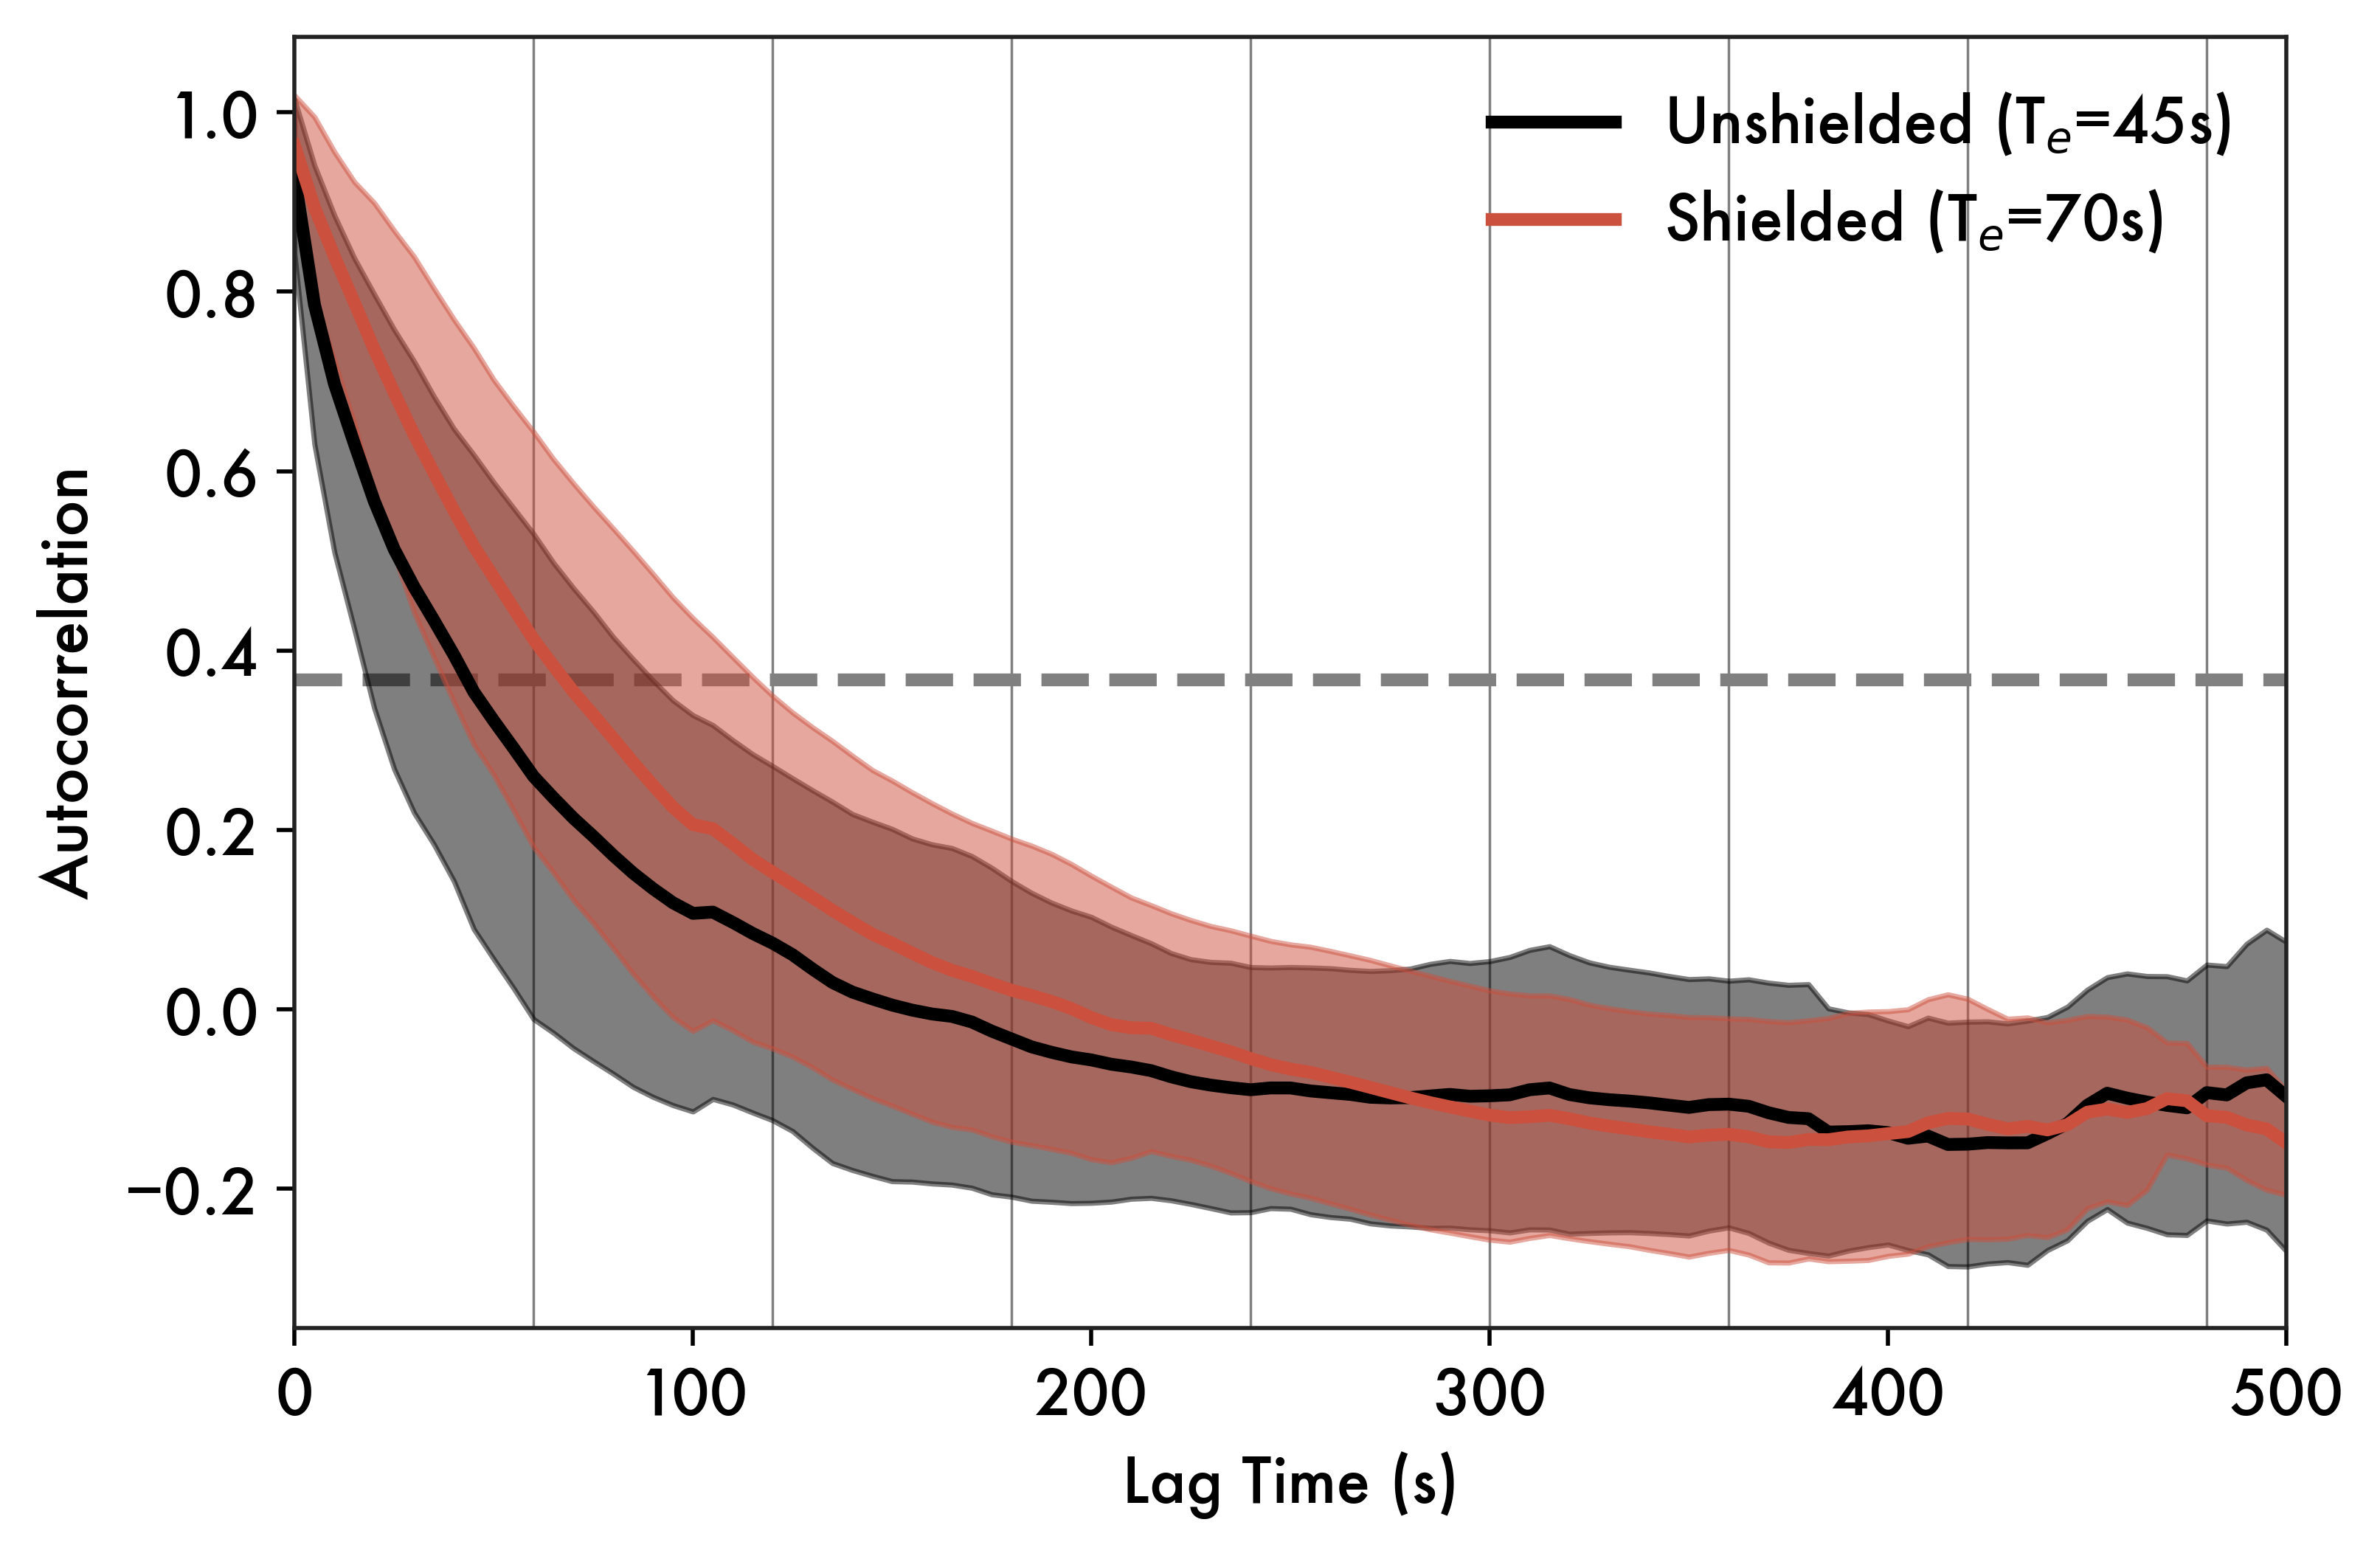

In [165]:
dt = 5

for df, label, col in zip(
    [un, asp], ["Unshielded", "Shielded"], ["black", red]
):
    df = df.stack()
    df.index = df.index.set_names(["flight", "lagtime"])
    df = df.reset_index()

    plot = df.groupby(dt * (df.lagtime // dt))[0]
    plt.plot(
        plot.mean(),
        color=col,
        label=f"{label} (T$_e$={etime(plot.mean(),dt=dt):.0f}s)",
    )

    plt.fill_between(
        plot.quantile(0.25).index,
        plot.mean() - plot.std(),  # plot.quantile(0.25),
        plot.mean() + plot.std(),  # plot.quantile(0.75),
        color=col,
        alpha=0.5,
    )


plt.legend(loc="upper right")

plt.xlim(0, 500)

plt.axhline(1 / np.e, ls="--", zorder=0, color="gray")


for y in [60, 120, 180, 240, 300, 360, 420, 480]:
    plt.axvline(y, color="gray", zorder=0, lw=0.5)

plt.xlabel("Lag Time (s)")
plt.ylabel("Autocorrelation")

# Plot all e-folding times

Text(0, 0.5, 'Shielded  T$_e$ (min)')

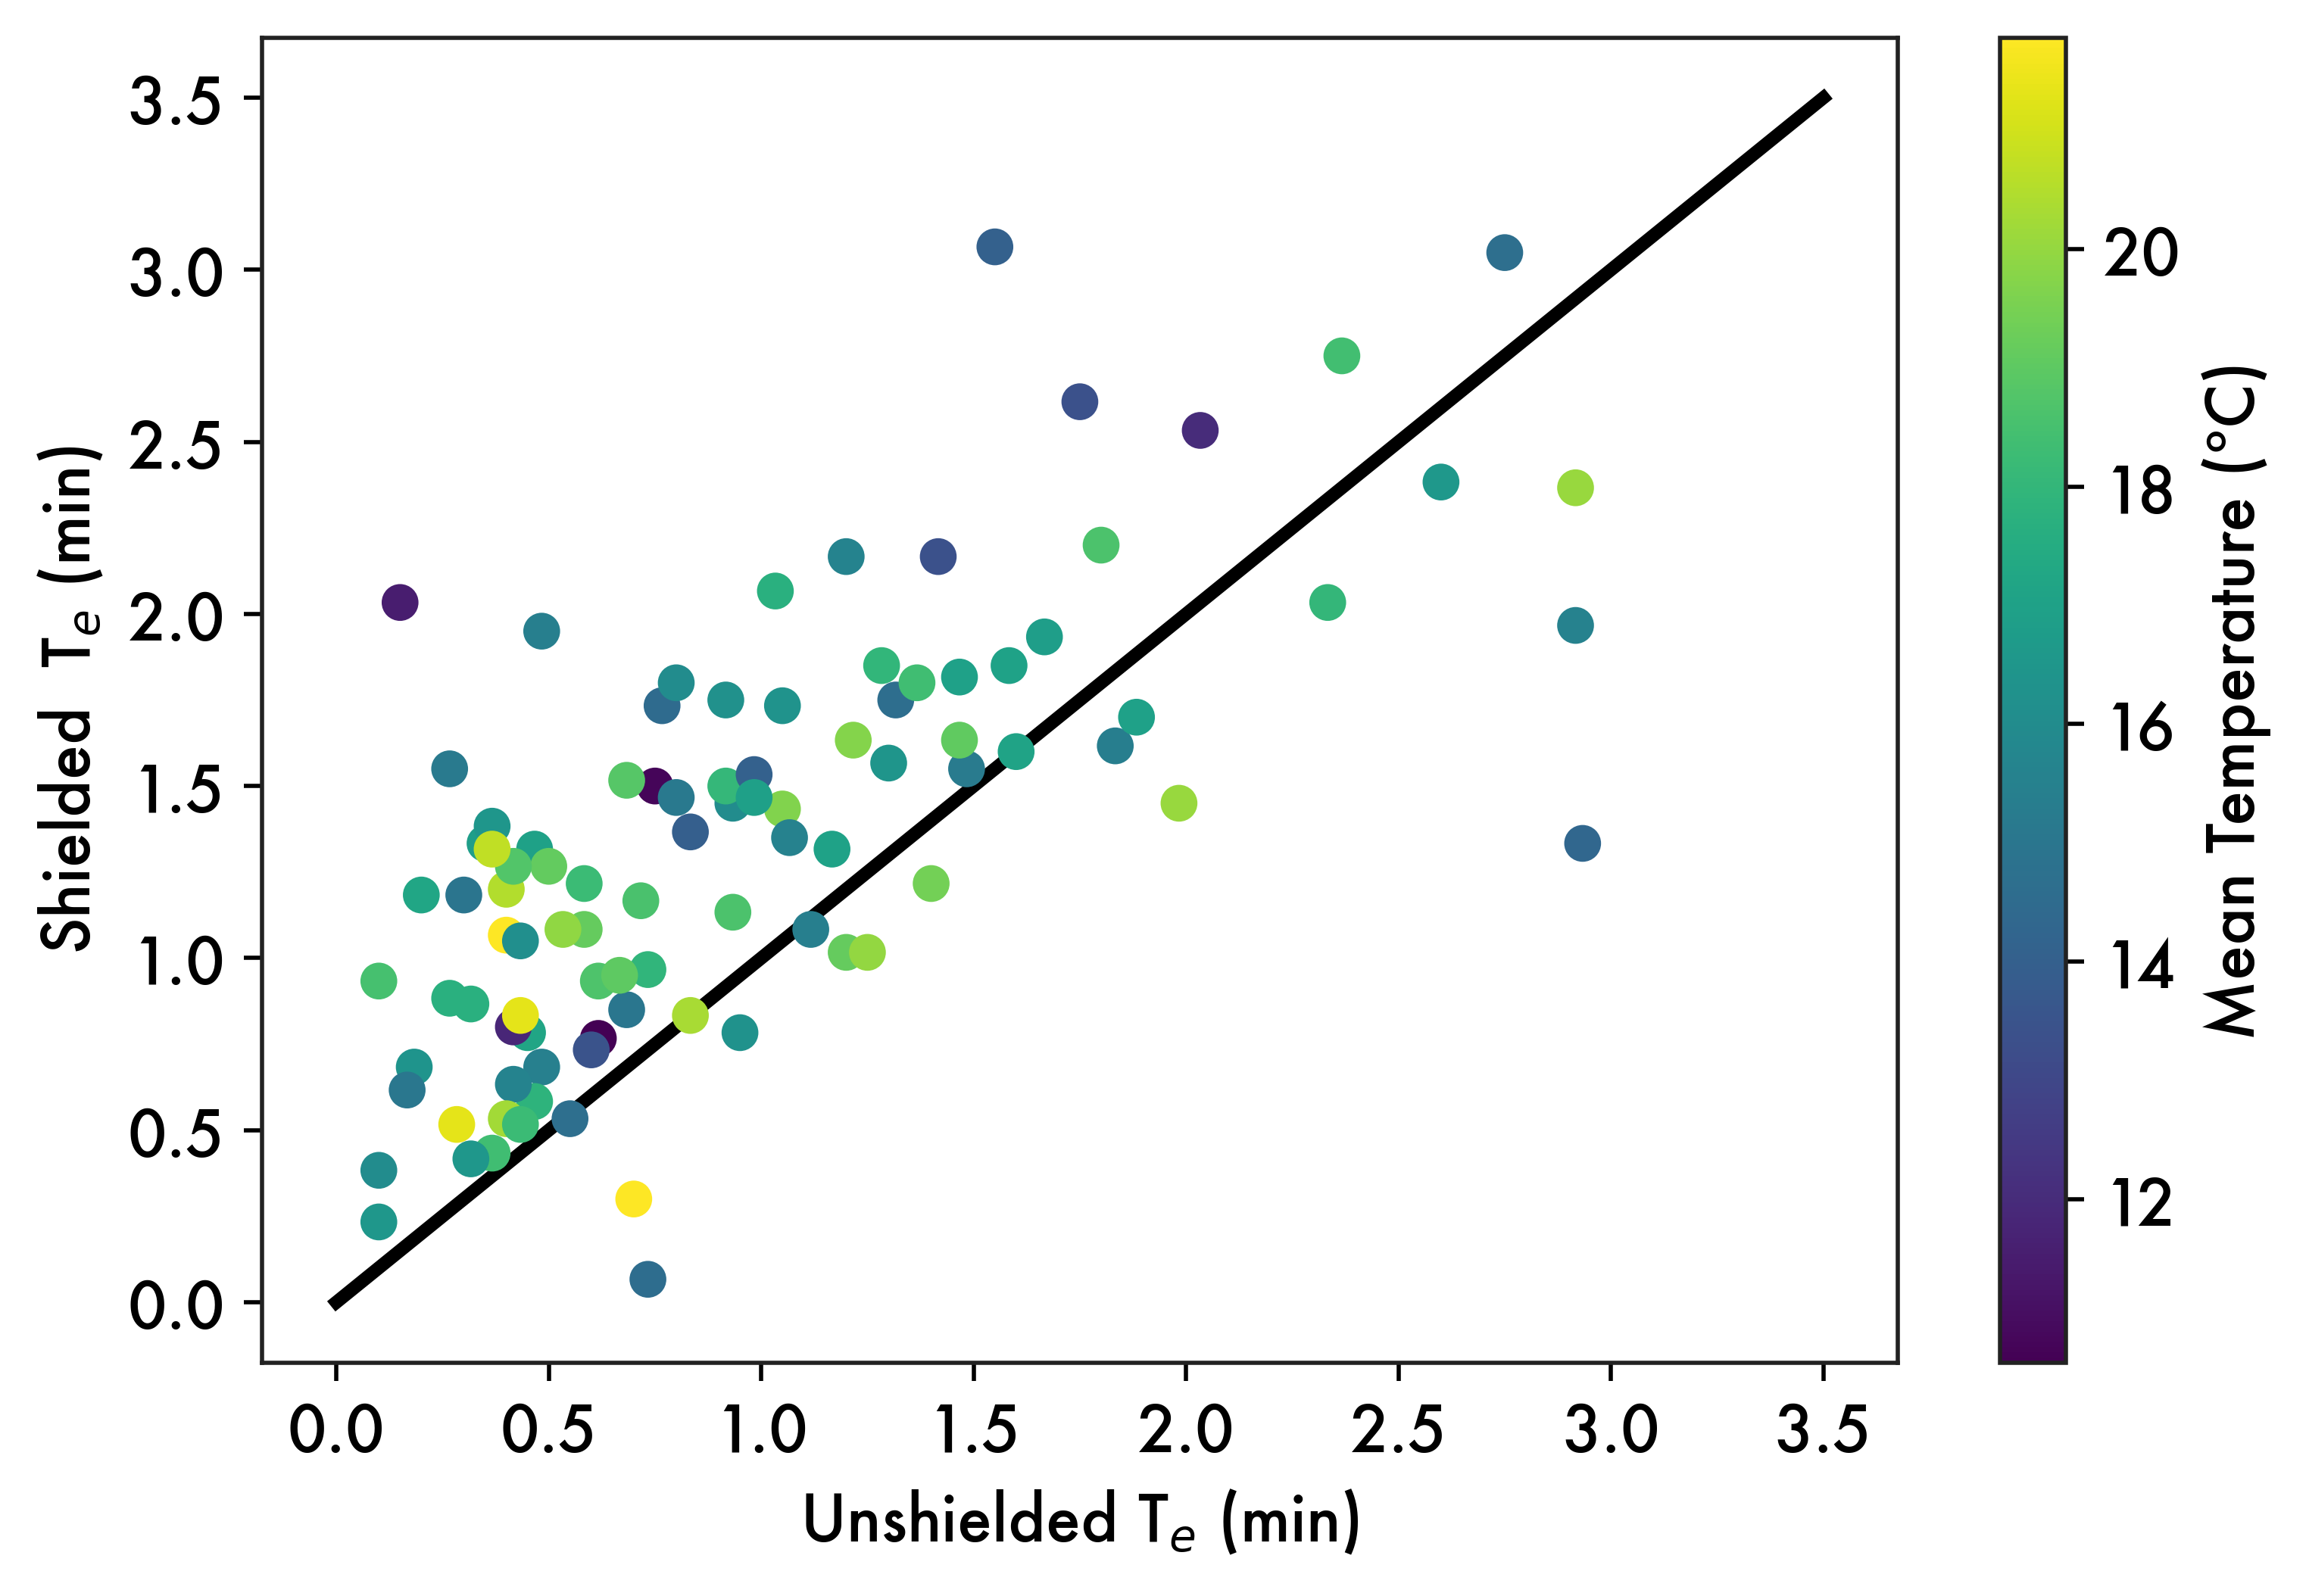

In [166]:
a = pd.DataFrame(
    a, columns=["IOP", "Drone", "Alt", "Te_a", "Te_u", "Temp_a", "Temp_u"]
)

c = plt.scatter(a.Te_u / 60, a.Te_a / 60, c=(a.Temp_a + a.Temp_u) / 2)
plt.colorbar(c, label="Mean Temperature (ºC)")
plt.plot([0, 210 / 60], [0, 210 / 60], color="black", zorder=0)
plt.xlabel("Unshielded T$_e$ (min)")
plt.ylabel("Shielded  T$_e$ (min)")